In [1]:
import cv2
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [87]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'nastro', 'pappagallo', 'penna', 'spillatrice']
tp_tot, tn_tot, fp_tot, fn_tot = [], [], [], []


yolo_model = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")


for tool in tqdm(tools):

    with open(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):
        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])

        image = cv2.imread(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_{pos+1}.png")

        # Preprocessing delle immagini: conversione in scala di grigi.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Applicare ground truth all'immagine.
        truth_mask = np.zeros_like(threshold)
        cv2.fillPoly(truth_mask, [vertices], 255)
        truth_mask = truth_mask.astype(bool).flatten()

        # 1) 58%
        # kernel = np.ones((5,5), np.uint8)
        # opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)

        # 2) 66%
        # edges = cv2.Canny(threshold, threshold1=200, threshold2=900)
        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # edges = cv2.Canny(threshold, threshold1=20, threshold2=200)


        input_image = cv2.resize(image, (416, 416))
        yolo_model.setInput(cv2.dnn.blobFromImage(input_image, 1/255.0, (416, 416), swapRB=True, crop=False))
        yolo_output = yolo_model.forward(["yolo_82", "yolo_94", "yolo_106"])
        print(yolo_output[0])
        mask = cv2.threshold(yolo_output[0], 0.5, 255, cv2.THRESH_BINARY)[1].astype('uint8')
        print(mask.shape)
        segmented_image = cv2.bitwise_and(input_image, input_image, mask=mask)


        opening = segmented_image.astype(bool)
        opening = np.array([not elem for elem in opening.flatten()])

        # Confronto tra segmentazione e ground truth.
        ground_truth = truth_mask.flatten()
        predictions = [not elem for elem in opening.flatten()]
        tn, fp, fn, tp = confusion_matrix(ground_truth, predictions, labels=[True, False]).ravel()
        tp_tot.append(tp)
        tn_tot.append(tn)
        fp_tot.append(fp)
        fn_tot.append(fn)

  0%|          | 0/10 [00:01<?, ?it/s]

[[0.04817301 0.0331963  0.24037144 ... 0.         0.         0.        ]
 [0.05127843 0.0330331  0.2208218  ... 0.         0.         0.        ]
 [0.05158268 0.03098811 0.95951784 ... 0.         0.         0.        ]
 ...
 [0.9675611  0.95663047 0.4342801  ... 0.         0.         0.        ]
 [0.96433705 0.9623503  0.29471108 ... 0.         0.         0.        ]
 [0.9681673  0.95853174 0.83766407 ... 0.         0.         0.        ]]
(507, 85)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


In [88]:
13*13*3

507

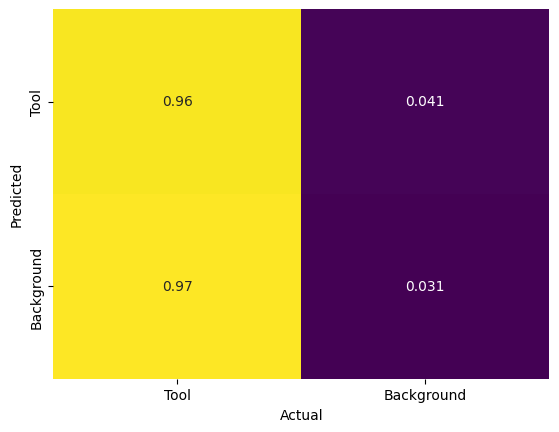

In [33]:
sum_tp = sum(tp_tot)
sum_tn = sum(tn_tot)
sum_fp = sum(fp_tot)
sum_fn = sum(fn_tot)




cf_matrix = np.array([[sum_tp/(sum_tp+sum_fp), sum_fp/(sum_tp+sum_fp)],
                       [sum_fn/(sum_tn+sum_fn), sum_tn/(sum_tn+sum_fn)]])

labels = ['Tool', 'Background']
sns.heatmap(cf_matrix, annot=True, cmap='viridis',  xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted');